In [113]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from skimage import io

Carregamento e resizing da imagem

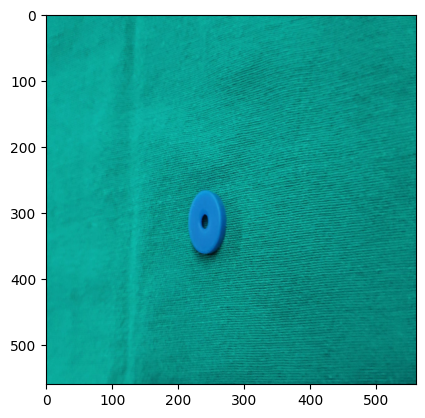

In [114]:
nstrmnt = "cabo"
img = io.imread(r"\\storage01\Robotica\Dataset CME\ferramentas desmontadas kit trocater\3\2\fotos\frame_0132.jpg")
dim = 560
img = cv2.resize(img, (dim,dim), interpolation=cv2.INTER_AREA)
plt.imshow(img)

Conversão de esquema de cores para melhor extração de características

Text(0.5, 1.0, 'Luminance')

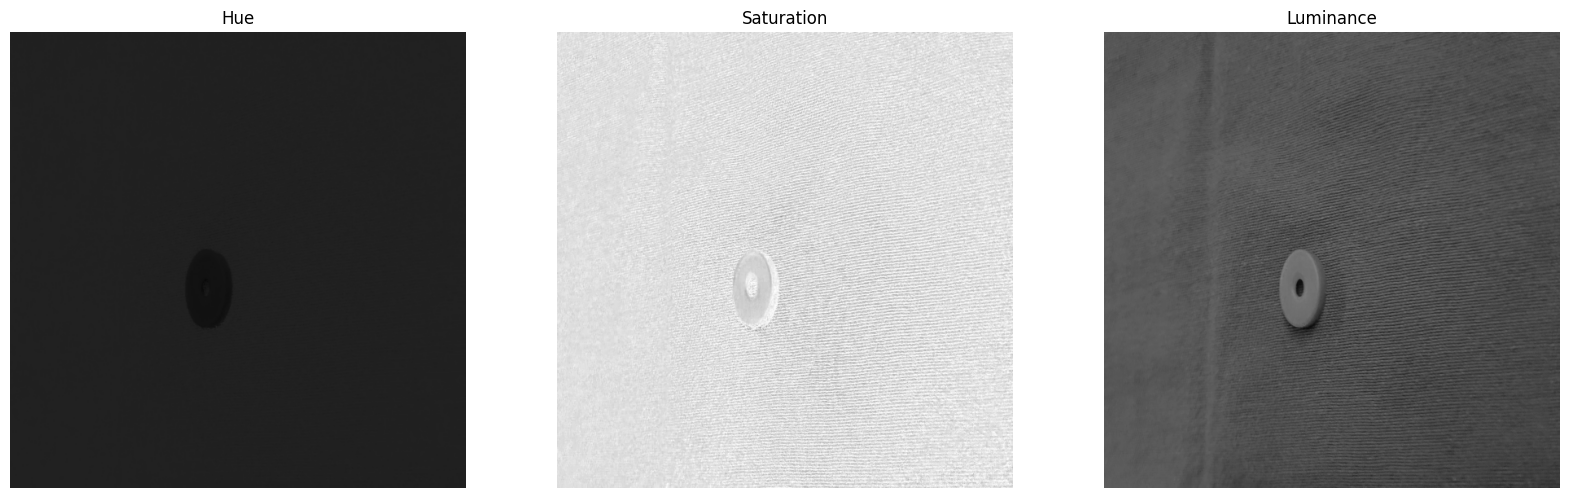

In [115]:
hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)

h = hsv_img.copy()
h[:,:,1], h[:,:,2] = hsv_img[:,:,0], hsv_img[:,:,0]
s = hsv_img.copy()
s[:,:,0], s[:,:,1] = hsv_img[:,:,2], hsv_img[:,:,2]
l = hsv_img.copy()
l[:,:,0], l[:,:,2] = hsv_img[:,:,1], hsv_img[:,:,1]

fig = plt.figure(figsize=(20, 21))
fig.add_subplot(1, 3, 1)
plt.imshow(h)
plt.axis('off')
plt.title("Hue")

fig.add_subplot(1, 3, 2)
plt.imshow(s)
plt.axis('off')
plt.title("Saturation")

fig.add_subplot(1, 3, 3)
plt.imshow(l)
plt.axis('off')
plt.title("Luminance")

Ciação da máscara

Text(0.5, 1.0, 'Final Thresh')

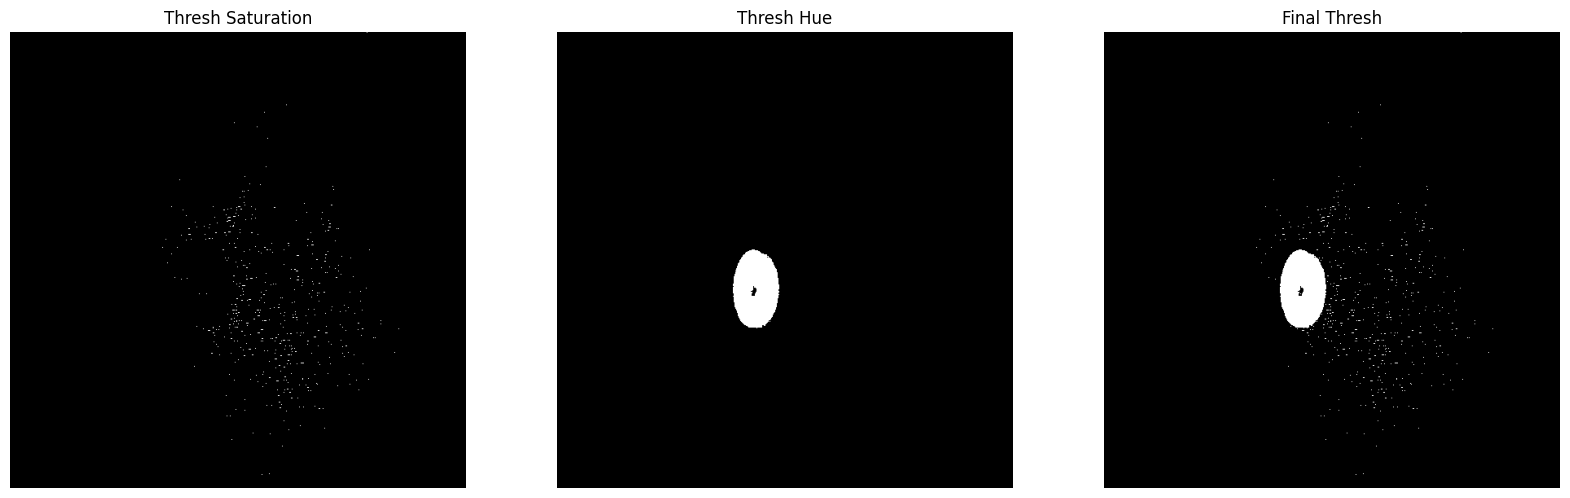

In [116]:
ret, thrsld_1 = cv2.threshold(s, 180, 255, cv2.THRESH_BINARY_INV)
ret, thrsld_2 = cv2.threshold(h, 21, 255, cv2.THRESH_BINARY_INV)
thrsld = thrsld_1 + thrsld_2

fig = plt.figure(figsize=(20, 21))
fig.add_subplot(1, 3, 1)
plt.imshow(thrsld_1)
plt.axis('off')
plt.title("Thresh Saturation")

fig.add_subplot(1, 3, 2)
plt.imshow(thrsld_2)
plt.axis('off')
plt.title("Thresh Hue")

fig.add_subplot(1, 3, 3)
plt.imshow(thrsld)
plt.axis('off')
plt.title("Final Thresh")

Floodfill sobre elementos localizados sobre a borda

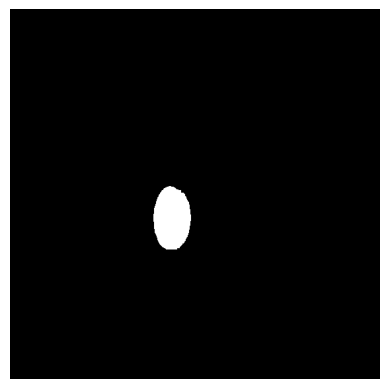

In [117]:
h, w = thrsld.shape[:2]
floodfill = thrsld.copy()

kernel = np.ones((2, 2), np.uint8)
floodfill = cv2.erode(floodfill, kernel, iterations=1)
floodfill = cv2.dilate(floodfill, kernel, iterations=1)

kernel = np.ones((9, 9), np.uint8)

floodfill = cv2.dilate(floodfill, kernel, iterations=1)

# create zeros mask 2 pixels larger in each dimension
mask = np.zeros([h + 2, w + 2], np.uint8)

# floodfill outer white border with black
for i in range(0, dim):
    floodfill[0,i] = 255,255,255
    floodfill[i,0] = 255,255,255
    floodfill[dim-1,i] = 255,255,255
    floodfill[i,dim-1] = 255,255,255
cv2.floodFill(floodfill, mask, (0,0), (0, 0, 0), (128,128,128), (255,255,255))

thrsld = cv2.erode(floodfill, kernel, iterations=1)


plt.axis('off')
new = cv2.bitwise_and(thrsld, thrsld, mask=np.zeros((h, w), 'uint8'))

for y, line in enumerate(thrsld):
    for x, pxl in enumerate(line):
        if pxl[0] >= 128:
            pxl[:3] = 255,255,255
        else:
            pxl[:3] = 0,0,0

contours, _ = cv2.findContours(cv2.cvtColor(thrsld, cv2.COLOR_BGR2GRAY), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
for cnt in contours:
    if cv2.contourArea(cnt) > 300:
        mask = np.zeros((h, w), 'uint8')
        cv2.drawContours(mask, [cnt], -1, 255, -1) 
        new += cv2.bitwise_and(thrsld, thrsld, mask=mask)

thrsld = new
plt.imshow(new)
# print(contours)

Varredura da máscara para localizar máximos e mínimos

In [118]:
max = [None, None]
min = [None, None]
border = 0

for y, line in enumerate(thrsld):
    for x, pxl in enumerate(line):
        if y <= border \
           or y >= thrsld.shape[0] - border \
           or x <= border \
           or x >= thrsld.shape[1] - border:
            continue
        if pxl[0] >= 200:
            if max[0] is None or max[0] < x:
                max[0] = x
            if max[1] is None or max[1] < y:
                max[1] = y
            
            if min[0] is None or min[0] > x:
                min[0] = x
            if min[1] is None or min[1] > y:
                min[1] = y
            

Demarcação de box para melhor visualização

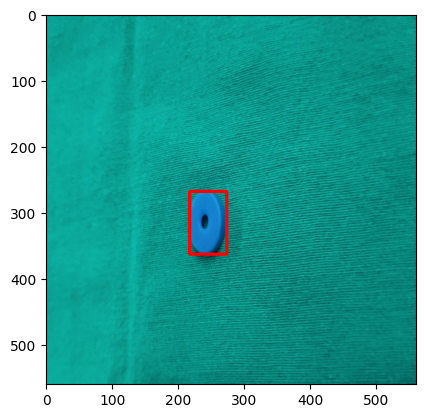

In [119]:
img2 = cv2.rectangle(img, min, max, [255,0,0], 3)
# img2 = cv2.rectangle(img, [border, thrsld.shape[0] - border], [thrsld.shape[1] - border, border], [255,255,0], 3)
plt.imshow(img2)